<a href="https://colab.research.google.com/github/minhmax098/U-Net-LUNA16/blob/main/Unet_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pwd

/content/drive/MyDrive/LUNA16/Lung-nodule-detection-LUNA-16


In [35]:
# !mv ../annotations.csv dataset

In [33]:
!ls

data  data_prep  dataset  LICENSE  Plots  README.md  train_codes


In [1]:
import os
os.chdir('/content/drive/MyDrive/LUNA16/Lung-nodule-detection-LUNA-16')

In [16]:
# Run this once
# !git clone https://github.com/Rakshith2597/Lung-nodule-detection-LUNA-16.git

## Inspect the dataset

In [2]:
!pip install SimpleITK
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 11.7 MB/s eta 0:00:00


In [25]:
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)

In [26]:
def make_mask(center,diam,z,width,height,spacing,origin):
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int((diam+5)/spacing[0])
    v_xmin = np.max([0,int(v_center[0]-v_diam)])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)])
    v_ymin = np.max([0,int(v_center[1]-v_diam)])
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [27]:
def matrix2int16(matrix):
    '''
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

In [28]:
train_pts = np.load('./data_prep/train_pts.npy')
val_pts = np.load('./data_prep/val_pts.npy')
test_pts = np.load('./data_prep/test_pts.npy')

In [29]:
luna_path="./dataset/"
tr_output_img_path="./data/train/images/"
tr_output_mask_path="./data/train/labels/"

if not os.path.isdir(tr_output_img_path):
    os.makedirs(tr_output_img_path)
if not os.path.isdir(tr_output_mask_path):
    os.makedirs(tr_output_mask_path)

v_output_img_path="./data/val/images/"
v_output_mask_path="./data/val/labels/"

if not os.path.isdir(v_output_img_path):
    os.makedirs(v_output_img_path)
if not os.path.isdir(v_output_mask_path):
    os.makedirs(v_output_mask_path)

ts_output_img_path="./data/test/images/"
ts_output_mask_path="./data/test/labels/"

if not os.path.isdir(ts_output_img_path):
    os.makedirs(ts_output_img_path)
if not os.path.isdir(ts_output_mask_path):
    os.makedirs(ts_output_mask_path)

In [44]:
#!cat ./dataset/annotations.csv

In [ ]:
# 6, 7 0 9 4 8

In [70]:
fcount = 0

# Run once
for tr in list(train_pts):
    print('Set:',tr)
    # continue
    luna_subset_path="./dataset/subset"+str(tr)+"/"
    file_list=glob(luna_subset_path+"*.mhd")
    df_node = pd.read_csv(luna_path+"annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    for img_file in tq(file_list):
        #print "Getting mask for image file %s" % img_file.replace(luna_subset_path,"")
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
#         print(len(mini_df))
        if len(mini_df)>0:       # some files may not have a nodule--skipping those
            biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
            node_x = mini_df["coordX"].values[biggest_node]
            node_y = mini_df["coordY"].values[biggest_node]
            node_z = mini_df["coordZ"].values[biggest_node]
            diam = mini_df["diameter_mm"].values[biggest_node]

            itk_img = sitk.ReadImage(img_file)
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            center = np.array([node_x,node_y,node_z])   # nodule center
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            num_z, height, width = img_array.shape

            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)

            for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
                mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
                masks = mask
    #             imgs = matrix2int16(img_array[i_z])
                imgs = img_array[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the
                # underflow and overflow on the pixel spectrum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
    #             print('orig:',img_array[i_z].max())
    #             print('int16:',imgs.max())
                np.save(tr_output_img_path+"images_"+str(fcount)+".npy",imgs)
                np.save(tr_output_mask_path+"masks_"+str(fcount)+".npy",masks)

                fcount +=1

Set: 6


/tmp/ipython-input-995719297.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Set: 7


/tmp/ipython-input-995719297.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Set: 0


/tmp/ipython-input-995719297.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Set: 9


/tmp/ipython-input-995719297.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/88 [00:00<?, ?it/s]

Set: 4


/tmp/ipython-input-995719297.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Set: 8


/tmp/ipython-input-995719297.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/88 [00:00<?, ?it/s]

In [62]:
!mv ./dataset/subset0 ./dataset/sub

subset1


In [57]:
!ls ./dataset/subset6/subset6 | grep mdh | wc -l

ls: cannot access './dataset/subset6/subset6': No such file or directory
0


In [53]:
tmp = glob("./dataset/subset1/*mdh")
len(tmp)

0

In [69]:
fcount = 0
for val in list(val_pts):
    print('Set:',val)
    luna_subset_path="./dataset/subset"+str(val)+"/"
    file_list=glob(luna_subset_path+"*.mhd")
    print(f"Total files: {len(file_list)}")
    df_node = pd.read_csv(luna_path+"annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    for img_file in tq(file_list):
        print("Getting mask for image file %s" % img_file.replace(luna_subset_path,""))
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
#         print(len(mini_df))
        if len(mini_df)>0:       # some files may not have a nodule--skipping those
            biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
            node_x = mini_df["coordX"].values[biggest_node]
            node_y = mini_df["coordY"].values[biggest_node]
            node_z = mini_df["coordZ"].values[biggest_node]
            diam = mini_df["diameter_mm"].values[biggest_node]

            itk_img = sitk.ReadImage(img_file)
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            center = np.array([node_x,node_y,node_z])   # nodule center
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            num_z, height, width = img_array.shape

            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)

            for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
                mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
                masks = mask
    #             imgs = mavalix2int16(img_array[i_z])
                imgs = img_array[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the
                # underflow and overflow on the pixel specvalum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
    #             print('orig:',img_array[i_z].max())
    #             print('int16:',imgs.max())
                np.save(v_output_img_path+"images_"+str(fcount)+".npy",imgs)
                np.save(v_output_mask_path+"masks_"+str(fcount)+".npy",masks)

                fcount +=1

Set: 1
Total files: 89


/tmp/ipython-input-2980028877.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
Getting mask for image file 1.

/tmp/ipython-input-2980028877.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.126704785377921920210612476953.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.133378195429627807109985347209.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628.mhd
Getting mask for image file 1.

In [71]:
fcount = 0
for ts in list(test_pts):
    print('Set:',ts)
    luna_subset_path="./dataset/subset"+str(ts)+"/"
    file_list=glob(luna_subset_path+"*.mhd")
    df_node = pd.read_csv(luna_path+"annotations.csv")
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()
    for img_file in tq(file_list):
        #print "Getting mask for image file %s" % img_file.replace(luna_subset_path,"")
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
#         print(len(mini_df))
        if len(mini_df)>0:       # some files may not have a nodule--skipping those
            biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]  # just using the biggest node
            node_x = mini_df["coordX"].values[biggest_node]
            node_y = mini_df["coordY"].values[biggest_node]
            node_z = mini_df["coordZ"].values[biggest_node]
            diam = mini_df["diameter_mm"].values[biggest_node]

            itk_img = sitk.ReadImage(img_file)
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            center = np.array([node_x,node_y,node_z])   # nodule center
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            num_z, height, width = img_array.shape

#             center = np.array([node_x, node_y, node_z])   # nodule center
#             v_center = np.rint((center-origin)/spacing)

            for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
                mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
                masks = mask
    #             imgs = matsix2int16(img_array[i_z])
                imgs = img_array[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the
                # underflow and overflow on the pixel spectsum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
    #             print('orig:',img_array[i_z].max())
    #             print('int16:',imgs.max())
                np.save(ts_output_img_path+"images_"+str(fcount)+".npy",imgs)
                np.save(ts_output_mask_path+"masks_"+str(fcount)+".npy",masks)

                fcount +=1

Set: 3


/tmp/ipython-input-1192684626.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

Set: 5


/tmp/ipython-input-1192684626.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_file in tq(file_list):


  0%|          | 0/89 [00:00<?, ?it/s]

In [72]:
print("value of x=",node_x)
print("value of y=",node_y)
print("value of z=",node_z)
print("value of diameter=",diam)

value of x= -85.60344693
value of y= 29.06733423
value of z= -107.8464475
value of diameter= 7.296371673


(512, 512)
Img min: -1024 Img max: 2996


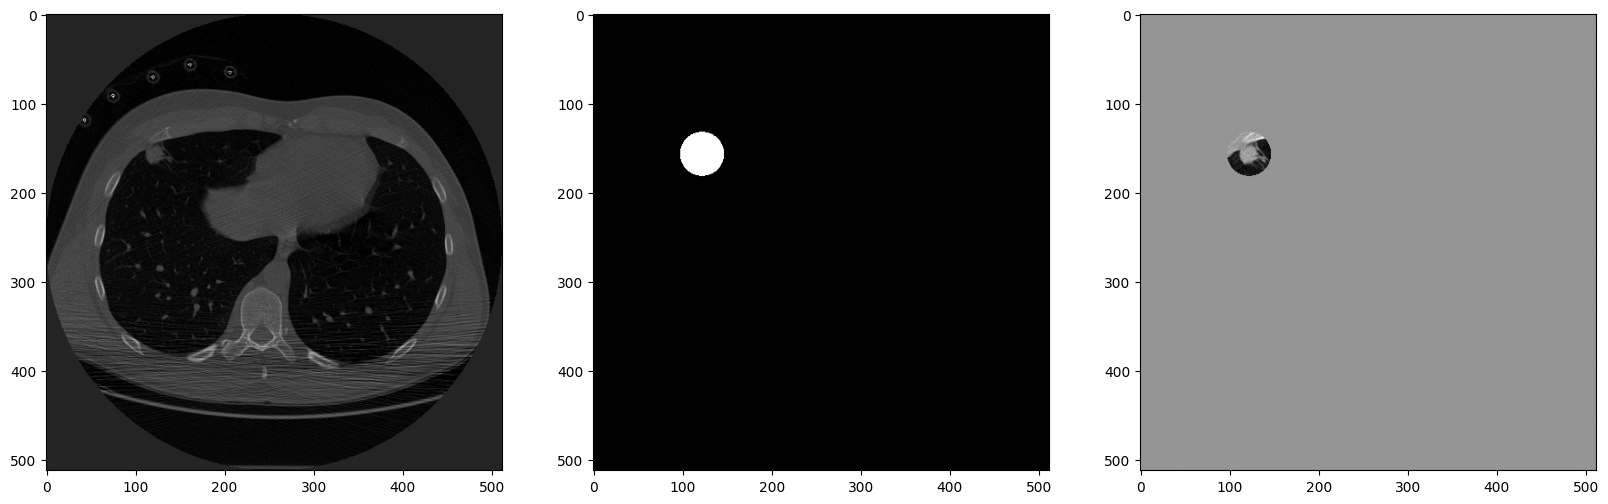

In [73]:
imgs = np.load(tr_output_img_path+'images_1.npy')
print(np.shape(imgs))
print('Img min:',imgs.min(),'Img max:',imgs.max())
# imgs[imgs==imgs.min()] = 0

masks = np.load(tr_output_mask_path+'masks_1.npy')

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs,cmap='gray')
plt.subplot(132)
plt.imshow(masks,cmap='gray')
plt.subplot(133)
plt.imshow((imgs)*masks,cmap='gray')

# imgs = np.load(output_path+'images_1.npy')
# masks = np.load(output_path+'masks_1.npy')

# plt.figure(figsize=[20,10])
# plt.subplot(131)
# plt.imshow(imgs,cmap='gray')
# plt.subplot(132)
# plt.imshow(masks,cmap='gray')
# plt.subplot(133)
# plt.imshow(imgs*masks,cmap='gray')

# imgs = np.load(output_path+'images_2.npy')
# masks = np.load(output_path+'masks_2.npy')

# plt.figure(figsize=[20,10])
# plt.subplot(131)
# plt.imshow(imgs,cmap='gray')
# plt.subplot(132)
# plt.imshow(masks,cmap='gray')
# plt.subplot(133)
# plt.imshow(imgs*masks,cmap='gray')

(512, 512)
Img min: -1024 Img max: 2996


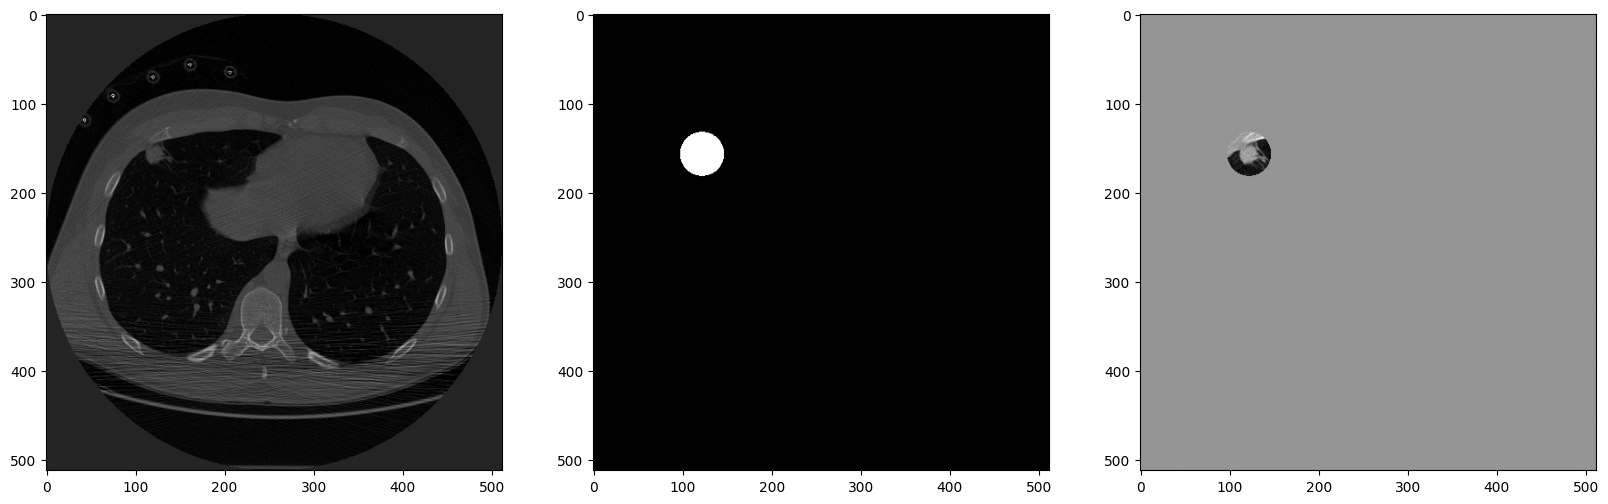

In [74]:
imgs = np.load(tr_output_img_path+'images_1.npy')
print(np.shape(imgs))
print('Img min:',imgs.min(),'Img max:',imgs.max())
# imgs[imgs==imgs.min()] = 0

masks = np.load(tr_output_mask_path+'masks_1.npy')

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs,cmap='gray')
plt.subplot(132)
plt.imshow(masks,cmap='gray')
plt.subplot(133)
plt.imshow((imgs)*masks,cmap='gray')

In [76]:
loadPath = './data/train/images/'
trFiles = os.listdir(loadPath)
print(len(trFiles))

1095


In [77]:
temp = np.load(loadPath+trFiles[0])
print(temp.shape)

(512, 512)


In [78]:
totalData = np.zeros((len(trFiles),512,512))
for n in tq(range(len(trFiles))):
    totalData[n] = np.load(loadPath+trFiles[n])

/tmp/ipython-input-4200796211.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tq(range(len(trFiles))):


  0%|          | 0/1095 [00:00<?, ?it/s]

In [79]:
print('Mean:',totalData.mean(),'Std:',totalData.std())


Mean: -464.62011798179316 Std: 444.22577401784525


In [80]:
print('Min:',totalData.min(),'Max:',totalData.max())

Min: -3186.0 Max: 8947.0


## Trainer

Always run from this step !!

### Dataloader

In [3]:
#Code written by Rakshith Sathish
#The work is made public with MIT License

import os
import collections
import torch
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


from torch.utils import data


class lunaLoader(data.Dataset):
    def __init__(self,split="train",is_transform=True,img_size=512):
        self.split = split
        self.path= "./data/"+self.split
        self.is_transform = is_transform
        self.img_size = img_size
        self.files = os.listdir(self.path+'/images/') # [image1_img.npy, image2_img.npy]

        self.img_tf = transforms.Compose(
            [   transforms.Resize(self.img_size),
                transforms.ToTensor(),
                transforms.Normalize([-460.466],[444.421])
            ])

        self.label_tf = transforms.Compose(
            [
            	transforms.Resize(self.img_size,interpolation=0),
                transforms.ToTensor(),
            ])



    def __len__(self):
        return len(self.files)

    def __getitem__(self,index):
        fname = self.files[index] # image1_img.npy, image1_label.npy
        img = Image.fromarray(np.load(self.path+'/images/'+fname).astype(float))
        im_id = fname.split('_')[1]
        label = Image.fromarray(np.load(self.path+'/labels/masks_'+im_id))

        if self.is_transform:
            img, label = self.transform(img,label)

        return img, label.squeeze(0)

    def transform(self,img,label):
        img = self.img_tf(img)
        label = self.label_tf(label)

        return img,label


/tmp/ipython-input-2200552432.py:8: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc as m


### Lovaz Losses

In [4]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x


def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

<>:81: SyntaxWarning: invalid escape sequence '\i'
<>:97: SyntaxWarning: invalid escape sequence '\i'
<>:141: SyntaxWarning: invalid escape sequence '\i'
<>:186: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:81: SyntaxWarning: invalid escape sequence '\i'
<>:97: SyntaxWarning: invalid escape sequence '\i'
<>:141: SyntaxWarning: invalid escape sequence '\i'
<>:186: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipython-input-1784916405.py:81: SyntaxWarning: invalid escape sequence '\i'
  logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
/tmp/ipython-input-1784916405.py:97: SyntaxWarning: invalid escape sequence '\i'
  logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
/tmp/ipython-input-1784916405.py:141: SyntaxWarning: invalid escape sequence '\i'
  logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
/tmp/ipython-input-1784916405.py:186: SyntaxWarning: "is" with 'str' lit

### Train

In [5]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


In [ ]:

#Code written by Rakshith Sathish
#The work is made public with MIT License

import segmentation_models_pytorch as smp

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import tqdm
import time
from torch.utils import data
import os
import torch.nn
import torch.nn.functional as F
from torch.autograd import  Variable
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from sklearn.metrics import confusion_matrix
# from SUMNet_bn import SUMNet
# from LUNA_loader import lunaLoader
# import lovasz_losses as L

def dice_coefficient(pred, target):
	predC = torch.argmax(F.softmax(pred,dim=1),dim=1)
	c = confusion_matrix(target.view(-1).cpu().numpy(), predC.view(-1).cpu().numpy(),labels=[0,1])
	TP = np.diag(c)
	FP = c.sum(axis=0) - np.diag(c)
	FN = c.sum(axis=1) - np.diag(c)
	TN = c.sum() - (FP + FN + TP)
	return (TP,FP,FN)



savePath = 'Results/Unet/Adam_1e-4_ep100_CE+Lov/'
if not os.path.isdir(savePath):
	os.makedirs(savePath)


trainDset = lunaLoader(is_transform=True, split='train',img_size=256)
valDset = lunaLoader(is_transform=True, split='val',img_size=256)

trainDataLoader = data.DataLoader(trainDset,batch_size=16,shuffle=True,num_workers=4,pin_memory=True)
validDataLoader = data.DataLoader(valDset,batch_size=16,shuffle=False,num_workers=4,pin_memory=True)

n_classes = 2
# net = SUMNet(in_ch=1,out_ch=n_classes)

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=n_classes,                      # model output channels (number of classes in your dataset)
)

use_gpu = torch.cuda.is_available()
if use_gpu:
	net = net.cuda()

optimizerS = optim.Adam(net.parameters(), lr = 1e-4, weight_decay = 1e-5)
criterionS = nn.CrossEntropyLoss()

epochs = 100
trainLoss = []
validLoss = []
trainDiceCoeff = []
validDiceCoeff = []
start = time.time()

bestValidDice = 0.0

for epoch in range(epochs):
	epochStart = time.time()
	trainRunningLoss = 0
	validRunningLoss = 0
	trainBatches = 0
	validBatches = 0

	train_tp = np.zeros(n_classes)
	train_fp = np.zeros(n_classes)
	train_fn = np.zeros(n_classes)

	val_tp = np.zeros(n_classes)
	val_fp = np.zeros(n_classes)
	val_fn = np.zeros(n_classes)


	net.train(True)
	for data1 in tqdm.tqdm(trainDataLoader):
		imgs, mask = data1
		# print(imgs.shape)
		if use_gpu:
			inputs = imgs.cuda()
			labels = mask.cuda()


		cpmap = net(Variable(inputs))
		cpmapD = F.softmax(cpmap,dim=1)

		LGce = criterionS(cpmap,labels.long())
		L_lov = lovasz_softmax(F.softmax(cpmap,dim=1),labels)
		LGseg = LGce+L_lov

		optimizerS.zero_grad()

		LGseg.backward()

		optimizerS.step()

		trainRunningLoss += LGseg.item()

		train_cf = dice_coefficient(cpmapD,labels)
		train_tp += train_cf[0]
		train_fp += train_cf[1]
		train_fn += train_cf[2]
		trainBatches += 1
		# break


	train_dice = (2*train_tp)/(2*train_tp + train_fp + train_fn )
	trainLoss.append(trainRunningLoss/trainBatches)
	trainDiceCoeff.append(train_dice)

	print("\n{}][{}]| LGseg: {:.4f} | "
		.format(epoch,epochs,LGseg.item()))

	with torch.no_grad():
		for data1 in tqdm.tqdm(validDataLoader):
			imgs, mask = data1
			if use_gpu:
				inputs = imgs.cuda()
				labels = mask.cuda()


			cpmap = net(Variable(inputs))
			cpmapD = F.softmax(cpmap.data,dim=1)

			val_cf = dice_coefficient(cpmapD,labels)
			val_tp += val_cf[0]
			val_fp += val_cf[1]
			val_fn += val_cf[2]
			validRunningLoss += LGseg.item()
			validBatches += 1
			# break


		val_dice = (2*val_tp)/(2*val_tp + val_fp + val_fn )
		validLoss.append(validRunningLoss/validBatches)
		validDiceCoeff.append(val_dice)
	# scheduler.step(validRunningLoss/validBatches)
	if (val_dice[1] > bestValidDice):
		bestValidDice = val_dice[1]
		torch.save(net.state_dict(), savePath+'sumnet_best.pt')


	plt.figure()
	plt.plot(range(len(trainLoss)),trainLoss,'-r',label='Train')
	plt.plot(range(len(validLoss)),validLoss,'-g',label='Valid')
	if epoch==0:
		plt.legend()
	plt.savefig(savePath+'LossPlot.png')
	plt.close()
	epochEnd = time.time()-epochStart
	print('Epoch: {:.0f}/{:.0f} | Train Loss: {:.3f} | Valid Loss: {:.3f}'\
		  .format(epoch+1, epochs, trainRunningLoss/trainBatches, validRunningLoss/validBatches))
	print('\nDice | Train  | BG {:.3f} | Nodule {:.3f} |\n Valid | BG: {:.3f} | Nodule {:.3f} |'
		  .format(train_dice[0],train_dice[1], val_dice[0], val_dice[1]))

	print('\nTime: {:.0f}m {:.0f}s'.format(epochEnd//60,epochEnd%60))
	trainLoss_np = np.array(trainLoss)
	validLoss_np = np.array(validLoss)
	trainDiceCoeff_np = np.array(trainDiceCoeff)
	validDiceCoeff_np = np.array(validDiceCoeff)

	print('Saving losses')

	torch.save(trainLoss_np, savePath+'trainLoss.pt')
	torch.save(validLoss_np, savePath+'validLoss.pt')
	torch.save(trainDiceCoeff_np, savePath+'trainDice.pt')
	torch.save(validDiceCoeff_np, savePath+'validDice.pt')
	# break


end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))
plt.figure()
plt.plot(range(len(trainLoss)),trainLoss,'-r')
plt.plot(range(len(validLoss)),validLoss,'-g')
plt.title('Loss plot')
plt.savefig(savePath+'trainLossFinal.png')
plt.close()

trainDiceCoeff_bg = [x[0] for x in trainDiceCoeff]
trainDiceCoeff_nodule = [x[1] for x in trainDiceCoeff]
plt.figure()
plt.plot(range(len(trainDiceCoeff_bg)),trainDiceCoeff_bg,'-r',label='BG')
plt.plot(range(len(trainDiceCoeff_nodule)),trainDiceCoeff_nodule,'-g',label='Nodule')
plt.legend()
plt.title('Dice coefficient: Train')
plt.savefig(savePath+'trainDice.png')
plt.close()

validDiceCoeff_bg = [x[0] for x in validDiceCoeff]
validDiceCoeff_nodule = [x[1] for x in validDiceCoeff]
plt.figure()
plt.plot(range(len(validDiceCoeff_bg)),validDiceCoeff_bg,'-r',label='BG')
plt.plot(range(len(validDiceCoeff_nodule)),validDiceCoeff_nodule,'-g',label='Nodule')
plt.legend()
plt.title('Dice coefficient: Valid')
plt.savefig(savePath+'validDice.png')
plt.close()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

100%|██████████| 69/69 [02:23<00:00,  2.08s/it]



0][100]| LGseg: 0.8809 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [01:00<00:00,  2.76s/it]


Epoch: 1/100 | Train Loss: 1.242 | Valid Loss: 0.881

Dice | Train  | BG 0.830 | Nodule 0.008 |
 Valid | BG: 0.983 | Nodule 0.022 |

Time: 3m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:24<00:00,  2.81it/s]



1][100]| LGseg: 0.9316 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:07<00:00,  2.88it/s]


Epoch: 2/100 | Train Loss: 0.780 | Valid Loss: 0.932

Dice | Train  | BG 0.994 | Nodule 0.046 |
 Valid | BG: 0.994 | Nodule 0.081 |

Time: 0m 33s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:25<00:00,  2.73it/s]



2][100]| LGseg: 0.5216 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.25it/s]


Epoch: 3/100 | Train Loss: 0.594 | Valid Loss: 0.522

Dice | Train  | BG 0.998 | Nodule 0.428 |
 Valid | BG: 0.998 | Nodule 0.455 |

Time: 0m 33s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:23<00:00,  2.92it/s]



3][100]| LGseg: 0.3880 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.45it/s]


Epoch: 4/100 | Train Loss: 0.454 | Valid Loss: 0.388

Dice | Train  | BG 0.999 | Nodule 0.705 |
 Valid | BG: 0.999 | Nodule 0.516 |

Time: 0m 29s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.01it/s]



4][100]| LGseg: 0.3281 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.45it/s]


Epoch: 5/100 | Train Loss: 0.354 | Valid Loss: 0.328

Dice | Train  | BG 0.999 | Nodule 0.788 |
 Valid | BG: 0.999 | Nodule 0.600 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:23<00:00,  2.89it/s]



5][100]| LGseg: 0.2395 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.43it/s]


Epoch: 6/100 | Train Loss: 0.281 | Valid Loss: 0.239

Dice | Train  | BG 0.999 | Nodule 0.824 |
 Valid | BG: 0.999 | Nodule 0.584 |

Time: 0m 29s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



6][100]| LGseg: 0.2363 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.13it/s]


Epoch: 7/100 | Train Loss: 0.225 | Valid Loss: 0.236

Dice | Train  | BG 1.000 | Nodule 0.858 |
 Valid | BG: 0.999 | Nodule 0.634 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.05it/s]



7][100]| LGseg: 0.1607 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.14it/s]


Epoch: 8/100 | Train Loss: 0.190 | Valid Loss: 0.161

Dice | Train  | BG 1.000 | Nodule 0.874 |
 Valid | BG: 0.999 | Nodule 0.632 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



8][100]| LGseg: 0.1391 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.41it/s]


Epoch: 9/100 | Train Loss: 0.162 | Valid Loss: 0.139

Dice | Train  | BG 1.000 | Nodule 0.890 |
 Valid | BG: 0.999 | Nodule 0.631 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.43it/s]



9][100]| LGseg: 0.1471 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.66it/s]


Epoch: 10/100 | Train Loss: 0.146 | Valid Loss: 0.147

Dice | Train  | BG 1.000 | Nodule 0.900 |
 Valid | BG: 0.999 | Nodule 0.645 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.06it/s]



10][100]| LGseg: 0.1038 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.53it/s]


Epoch: 11/100 | Train Loss: 0.130 | Valid Loss: 0.104

Dice | Train  | BG 1.000 | Nodule 0.907 |
 Valid | BG: 0.999 | Nodule 0.603 |

Time: 0m 29s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.43it/s]



11][100]| LGseg: 0.1625 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.09it/s]


Epoch: 12/100 | Train Loss: 0.118 | Valid Loss: 0.162

Dice | Train  | BG 1.000 | Nodule 0.917 |
 Valid | BG: 0.999 | Nodule 0.644 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



12][100]| LGseg: 0.1014 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.22it/s]


Epoch: 13/100 | Train Loss: 0.110 | Valid Loss: 0.101

Dice | Train  | BG 1.000 | Nodule 0.921 |
 Valid | BG: 0.999 | Nodule 0.645 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



13][100]| LGseg: 0.1967 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.34it/s]


Epoch: 14/100 | Train Loss: 0.107 | Valid Loss: 0.197

Dice | Train  | BG 1.000 | Nodule 0.920 |
 Valid | BG: 0.999 | Nodule 0.623 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.46it/s]



14][100]| LGseg: 0.0968 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.98it/s]


Epoch: 15/100 | Train Loss: 0.097 | Valid Loss: 0.097

Dice | Train  | BG 1.000 | Nodule 0.927 |
 Valid | BG: 0.999 | Nodule 0.629 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.48it/s]



15][100]| LGseg: 0.0980 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.51it/s]


Epoch: 16/100 | Train Loss: 0.088 | Valid Loss: 0.098

Dice | Train  | BG 1.000 | Nodule 0.935 |
 Valid | BG: 0.999 | Nodule 0.639 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.50it/s]



16][100]| LGseg: 0.1961 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.31it/s]


Epoch: 17/100 | Train Loss: 0.084 | Valid Loss: 0.196

Dice | Train  | BG 1.000 | Nodule 0.938 |
 Valid | BG: 0.999 | Nodule 0.648 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.05it/s]



17][100]| LGseg: 0.0564 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.51it/s]


Epoch: 18/100 | Train Loss: 0.075 | Valid Loss: 0.056

Dice | Train  | BG 1.000 | Nodule 0.945 |
 Valid | BG: 0.999 | Nodule 0.653 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.02it/s]



18][100]| LGseg: 0.1287 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.57it/s]


Epoch: 19/100 | Train Loss: 0.074 | Valid Loss: 0.129

Dice | Train  | BG 1.000 | Nodule 0.945 |
 Valid | BG: 0.999 | Nodule 0.652 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



19][100]| LGseg: 0.0760 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.37it/s]


Epoch: 20/100 | Train Loss: 0.071 | Valid Loss: 0.076

Dice | Train  | BG 1.000 | Nodule 0.946 |
 Valid | BG: 0.999 | Nodule 0.637 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.46it/s]



20][100]| LGseg: 0.0695 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.38it/s]


Epoch: 21/100 | Train Loss: 0.069 | Valid Loss: 0.069

Dice | Train  | BG 1.000 | Nodule 0.947 |
 Valid | BG: 0.999 | Nodule 0.647 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.51it/s]



21][100]| LGseg: 0.0609 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.52it/s]


Epoch: 22/100 | Train Loss: 0.063 | Valid Loss: 0.061

Dice | Train  | BG 1.000 | Nodule 0.951 |
 Valid | BG: 0.999 | Nodule 0.625 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.54it/s]



22][100]| LGseg: 0.0459 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


Epoch: 23/100 | Train Loss: 0.062 | Valid Loss: 0.046

Dice | Train  | BG 1.000 | Nodule 0.952 |
 Valid | BG: 0.999 | Nodule 0.648 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.48it/s]



23][100]| LGseg: 0.0506 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.55it/s]


Epoch: 24/100 | Train Loss: 0.063 | Valid Loss: 0.051

Dice | Train  | BG 1.000 | Nodule 0.951 |
 Valid | BG: 0.999 | Nodule 0.653 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:23<00:00,  2.96it/s]



24][100]| LGseg: 0.0446 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.46it/s]


Epoch: 25/100 | Train Loss: 0.059 | Valid Loss: 0.045

Dice | Train  | BG 1.000 | Nodule 0.954 |
 Valid | BG: 0.999 | Nodule 0.664 |

Time: 0m 29s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.04it/s]



25][100]| LGseg: 0.0725 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.26it/s]


Epoch: 26/100 | Train Loss: 0.057 | Valid Loss: 0.072

Dice | Train  | BG 1.000 | Nodule 0.954 |
 Valid | BG: 0.999 | Nodule 0.632 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



26][100]| LGseg: 0.0477 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.50it/s]


Epoch: 27/100 | Train Loss: 0.055 | Valid Loss: 0.048

Dice | Train  | BG 1.000 | Nodule 0.955 |
 Valid | BG: 0.999 | Nodule 0.646 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



27][100]| LGseg: 0.0553 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.30it/s]


Epoch: 28/100 | Train Loss: 0.061 | Valid Loss: 0.055

Dice | Train  | BG 1.000 | Nodule 0.949 |
 Valid | BG: 0.999 | Nodule 0.663 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.42it/s]



28][100]| LGseg: 0.0506 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.08it/s]


Epoch: 29/100 | Train Loss: 0.055 | Valid Loss: 0.051

Dice | Train  | BG 1.000 | Nodule 0.956 |
 Valid | BG: 0.999 | Nodule 0.656 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



29][100]| LGseg: 0.0401 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.40it/s]


Epoch: 30/100 | Train Loss: 0.058 | Valid Loss: 0.040

Dice | Train  | BG 1.000 | Nodule 0.951 |
 Valid | BG: 0.999 | Nodule 0.664 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:21<00:00,  3.14it/s]



30][100]| LGseg: 0.0440 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.52it/s]


Epoch: 31/100 | Train Loss: 0.048 | Valid Loss: 0.044

Dice | Train  | BG 1.000 | Nodule 0.961 |
 Valid | BG: 0.999 | Nodule 0.651 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



31][100]| LGseg: 0.0604 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.78it/s]


Epoch: 32/100 | Train Loss: 0.046 | Valid Loss: 0.060

Dice | Train  | BG 1.000 | Nodule 0.963 |
 Valid | BG: 0.999 | Nodule 0.639 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.45it/s]



32][100]| LGseg: 0.1211 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.57it/s]


Epoch: 33/100 | Train Loss: 0.046 | Valid Loss: 0.121

Dice | Train  | BG 1.000 | Nodule 0.964 |
 Valid | BG: 0.999 | Nodule 0.661 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



33][100]| LGseg: 0.0278 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.51it/s]


Epoch: 34/100 | Train Loss: 0.046 | Valid Loss: 0.028

Dice | Train  | BG 1.000 | Nodule 0.962 |
 Valid | BG: 0.999 | Nodule 0.640 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.44it/s]



34][100]| LGseg: 0.0659 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.05it/s]


Epoch: 35/100 | Train Loss: 0.041 | Valid Loss: 0.066

Dice | Train  | BG 1.000 | Nodule 0.966 |
 Valid | BG: 0.999 | Nodule 0.645 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.50it/s]



35][100]| LGseg: 0.0421 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.45it/s]


Epoch: 36/100 | Train Loss: 0.041 | Valid Loss: 0.042

Dice | Train  | BG 1.000 | Nodule 0.966 |
 Valid | BG: 0.999 | Nodule 0.645 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.50it/s]



36][100]| LGseg: 0.0332 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


Epoch: 37/100 | Train Loss: 0.041 | Valid Loss: 0.033

Dice | Train  | BG 1.000 | Nodule 0.966 |
 Valid | BG: 0.999 | Nodule 0.666 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:22<00:00,  3.04it/s]



37][100]| LGseg: 0.0815 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.55it/s]


Epoch: 38/100 | Train Loss: 0.040 | Valid Loss: 0.081

Dice | Train  | BG 1.000 | Nodule 0.967 |
 Valid | BG: 0.999 | Nodule 0.643 |

Time: 0m 29s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.48it/s]



38][100]| LGseg: 0.0430 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.05it/s]


Epoch: 39/100 | Train Loss: 0.043 | Valid Loss: 0.043

Dice | Train  | BG 1.000 | Nodule 0.962 |
 Valid | BG: 0.999 | Nodule 0.647 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



39][100]| LGseg: 0.0483 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.51it/s]


Epoch: 40/100 | Train Loss: 0.043 | Valid Loss: 0.048

Dice | Train  | BG 1.000 | Nodule 0.964 |
 Valid | BG: 0.999 | Nodule 0.641 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



40][100]| LGseg: 0.0452 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.60it/s]


Epoch: 41/100 | Train Loss: 0.039 | Valid Loss: 0.045

Dice | Train  | BG 1.000 | Nodule 0.967 |
 Valid | BG: 0.999 | Nodule 0.646 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



41][100]| LGseg: 0.0779 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.74it/s]


Epoch: 42/100 | Train Loss: 0.037 | Valid Loss: 0.078

Dice | Train  | BG 1.000 | Nodule 0.969 |
 Valid | BG: 0.999 | Nodule 0.659 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.50it/s]



42][100]| LGseg: 0.0371 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.47it/s]


Epoch: 43/100 | Train Loss: 0.035 | Valid Loss: 0.037

Dice | Train  | BG 1.000 | Nodule 0.971 |
 Valid | BG: 0.999 | Nodule 0.645 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.44it/s]



43][100]| LGseg: 0.0583 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.93it/s]


Epoch: 44/100 | Train Loss: 0.035 | Valid Loss: 0.058

Dice | Train  | BG 1.000 | Nodule 0.971 |
 Valid | BG: 0.999 | Nodule 0.647 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



44][100]| LGseg: 0.0733 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.48it/s]


Epoch: 45/100 | Train Loss: 0.035 | Valid Loss: 0.073

Dice | Train  | BG 1.000 | Nodule 0.970 |
 Valid | BG: 0.999 | Nodule 0.645 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:21<00:00,  3.23it/s]



45][100]| LGseg: 0.0376 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.49it/s]


Epoch: 46/100 | Train Loss: 0.035 | Valid Loss: 0.038

Dice | Train  | BG 1.000 | Nodule 0.970 |
 Valid | BG: 0.999 | Nodule 0.638 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



46][100]| LGseg: 0.0284 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.50it/s]


Epoch: 47/100 | Train Loss: 0.036 | Valid Loss: 0.028

Dice | Train  | BG 1.000 | Nodule 0.970 |
 Valid | BG: 0.999 | Nodule 0.643 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



47][100]| LGseg: 0.0310 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.61it/s]


Epoch: 48/100 | Train Loss: 0.036 | Valid Loss: 0.031

Dice | Train  | BG 1.000 | Nodule 0.970 |
 Valid | BG: 0.999 | Nodule 0.627 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



48][100]| LGseg: 0.0489 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.23it/s]


Epoch: 49/100 | Train Loss: 0.036 | Valid Loss: 0.049

Dice | Train  | BG 1.000 | Nodule 0.969 |
 Valid | BG: 0.999 | Nodule 0.631 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



49][100]| LGseg: 0.0384 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.22it/s]


Epoch: 50/100 | Train Loss: 0.038 | Valid Loss: 0.038

Dice | Train  | BG 1.000 | Nodule 0.967 |
 Valid | BG: 0.999 | Nodule 0.630 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



50][100]| LGseg: 0.0503 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.48it/s]


Epoch: 51/100 | Train Loss: 0.037 | Valid Loss: 0.050

Dice | Train  | BG 1.000 | Nodule 0.968 |
 Valid | BG: 0.999 | Nodule 0.648 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



51][100]| LGseg: 0.0258 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.52it/s]


Epoch: 52/100 | Train Loss: 0.036 | Valid Loss: 0.026

Dice | Train  | BG 1.000 | Nodule 0.968 |
 Valid | BG: 0.999 | Nodule 0.630 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



52][100]| LGseg: 0.0142 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.69it/s]


Epoch: 53/100 | Train Loss: 0.034 | Valid Loss: 0.014

Dice | Train  | BG 1.000 | Nodule 0.971 |
 Valid | BG: 0.999 | Nodule 0.672 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:21<00:00,  3.16it/s]



53][100]| LGseg: 0.0299 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.80it/s]


Epoch: 54/100 | Train Loss: 0.032 | Valid Loss: 0.030

Dice | Train  | BG 1.000 | Nodule 0.973 |
 Valid | BG: 0.999 | Nodule 0.651 |

Time: 0m 28s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



54][100]| LGseg: 0.0390 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.52it/s]


Epoch: 55/100 | Train Loss: 0.033 | Valid Loss: 0.039

Dice | Train  | BG 1.000 | Nodule 0.972 |
 Valid | BG: 0.999 | Nodule 0.624 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



55][100]| LGseg: 0.0210 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.19it/s]


Epoch: 56/100 | Train Loss: 0.032 | Valid Loss: 0.021

Dice | Train  | BG 1.000 | Nodule 0.972 |
 Valid | BG: 0.999 | Nodule 0.646 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



56][100]| LGseg: 0.0379 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.51it/s]


Epoch: 57/100 | Train Loss: 0.031 | Valid Loss: 0.038

Dice | Train  | BG 1.000 | Nodule 0.973 |
 Valid | BG: 0.999 | Nodule 0.644 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



57][100]| LGseg: 0.0197 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.46it/s]


Epoch: 58/100 | Train Loss: 0.030 | Valid Loss: 0.020

Dice | Train  | BG 1.000 | Nodule 0.973 |
 Valid | BG: 0.999 | Nodule 0.656 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.45it/s]



58][100]| LGseg: 0.0405 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.98it/s]


Epoch: 59/100 | Train Loss: 0.029 | Valid Loss: 0.040

Dice | Train  | BG 1.000 | Nodule 0.975 |
 Valid | BG: 0.999 | Nodule 0.641 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



59][100]| LGseg: 0.0240 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.58it/s]


Epoch: 60/100 | Train Loss: 0.029 | Valid Loss: 0.024

Dice | Train  | BG 1.000 | Nodule 0.976 |
 Valid | BG: 0.999 | Nodule 0.652 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.52it/s]



60][100]| LGseg: 0.0281 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.03it/s]


Epoch: 61/100 | Train Loss: 0.028 | Valid Loss: 0.028

Dice | Train  | BG 1.000 | Nodule 0.975 |
 Valid | BG: 0.999 | Nodule 0.643 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:21<00:00,  3.16it/s]



61][100]| LGseg: 0.0325 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.21it/s]


Epoch: 62/100 | Train Loss: 0.028 | Valid Loss: 0.033

Dice | Train  | BG 1.000 | Nodule 0.975 |
 Valid | BG: 0.999 | Nodule 0.644 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



62][100]| LGseg: 0.0175 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.26it/s]


Epoch: 63/100 | Train Loss: 0.030 | Valid Loss: 0.017

Dice | Train  | BG 1.000 | Nodule 0.974 |
 Valid | BG: 0.999 | Nodule 0.656 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



63][100]| LGseg: 0.0157 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.50it/s]


Epoch: 64/100 | Train Loss: 0.027 | Valid Loss: 0.016

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.659 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



64][100]| LGseg: 0.0279 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.96it/s]


Epoch: 65/100 | Train Loss: 0.029 | Valid Loss: 0.028

Dice | Train  | BG 1.000 | Nodule 0.975 |
 Valid | BG: 0.999 | Nodule 0.660 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.43it/s]



65][100]| LGseg: 0.0144 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.48it/s]


Epoch: 66/100 | Train Loss: 0.028 | Valid Loss: 0.014

Dice | Train  | BG 1.000 | Nodule 0.976 |
 Valid | BG: 0.999 | Nodule 0.666 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



66][100]| LGseg: 0.0139 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.94it/s]


Epoch: 67/100 | Train Loss: 0.027 | Valid Loss: 0.014

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.649 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.43it/s]



67][100]| LGseg: 0.0160 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.53it/s]


Epoch: 68/100 | Train Loss: 0.026 | Valid Loss: 0.016

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.660 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



68][100]| LGseg: 0.0323 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.31it/s]


Epoch: 69/100 | Train Loss: 0.027 | Valid Loss: 0.032

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.638 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.42it/s]



69][100]| LGseg: 0.0188 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.11it/s]


Epoch: 70/100 | Train Loss: 0.026 | Valid Loss: 0.019

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.652 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



70][100]| LGseg: 0.0189 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.56it/s]


Epoch: 71/100 | Train Loss: 0.026 | Valid Loss: 0.019

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.638 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.47it/s]



71][100]| LGseg: 0.0227 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.63it/s]


Epoch: 72/100 | Train Loss: 0.026 | Valid Loss: 0.023

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.654 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



72][100]| LGseg: 0.0842 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.57it/s]


Epoch: 73/100 | Train Loss: 0.027 | Valid Loss: 0.084

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.639 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.29it/s]



73][100]| LGseg: 0.0147 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.49it/s]


Epoch: 74/100 | Train Loss: 0.025 | Valid Loss: 0.015

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.647 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



74][100]| LGseg: 0.0191 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.47it/s]


Epoch: 75/100 | Train Loss: 0.024 | Valid Loss: 0.019

Dice | Train  | BG 1.000 | Nodule 0.979 |
 Valid | BG: 0.999 | Nodule 0.653 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.51it/s]



75][100]| LGseg: 0.0370 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.51it/s]


Epoch: 76/100 | Train Loss: 0.025 | Valid Loss: 0.037

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.633 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.51it/s]



76][100]| LGseg: 0.0194 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.55it/s]


Epoch: 77/100 | Train Loss: 0.026 | Valid Loss: 0.019

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.647 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.49it/s]



77][100]| LGseg: 0.0292 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.16it/s]


Epoch: 78/100 | Train Loss: 0.027 | Valid Loss: 0.029

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.636 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



78][100]| LGseg: 0.0166 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.50it/s]


Epoch: 79/100 | Train Loss: 0.026 | Valid Loss: 0.017

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.630 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



79][100]| LGseg: 0.0189 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  4.38it/s]


Epoch: 80/100 | Train Loss: 0.025 | Valid Loss: 0.019

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.657 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.43it/s]



80][100]| LGseg: 0.0613 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.88it/s]


Epoch: 81/100 | Train Loss: 0.026 | Valid Loss: 0.061

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.616 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.42it/s]



81][100]| LGseg: 0.0185 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:06<00:00,  3.32it/s]


Epoch: 82/100 | Train Loss: 0.028 | Valid Loss: 0.018

Dice | Train  | BG 1.000 | Nodule 0.975 |
 Valid | BG: 0.999 | Nodule 0.661 |

Time: 0m 27s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:19<00:00,  3.46it/s]



82][100]| LGseg: 0.0087 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:05<00:00,  3.76it/s]


Epoch: 83/100 | Train Loss: 0.025 | Valid Loss: 0.009

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.665 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.42it/s]



83][100]| LGseg: 0.1394 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.52it/s]


Epoch: 84/100 | Train Loss: 0.027 | Valid Loss: 0.139

Dice | Train  | BG 1.000 | Nodule 0.978 |
 Valid | BG: 0.999 | Nodule 0.649 |

Time: 0m 25s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



84][100]| LGseg: 0.0236 | 


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 22/22 [00:04<00:00,  4.50it/s]


Epoch: 85/100 | Train Loss: 0.026 | Valid Loss: 0.024

Dice | Train  | BG 1.000 | Nodule 0.977 |
 Valid | BG: 0.999 | Nodule 0.648 |

Time: 0m 26s
Saving losses


  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 78%|███████▊  | 54/69 [00:16<00:04,  3.71it/s]

In [63]:
!mv /content/dataset/subset0/subset0/* /content/dataset/subset0/
!rm -r /content/dataset/subset0/subset0

mv: cannot stat '/content/dataset/subset0/subset0/*': No such file or directory
rm: cannot remove '/content/dataset/subset0/subset0': No such file or directory


In [64]:
BASE="/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset"

!mv $BASE/subset0/subset0/* $BASE/subset0/
!rm -r $BASE/subset0/subset0

!mv $BASE/subset1/subset1/* $BASE/subset1/
!rm -r $BASE/subset1/subset1


mv: cannot stat '/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset/subset0/subset0/*': No such file or directory
rm: cannot remove '/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset/subset0/subset0': No such file or directory
mv: cannot stat '/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset/subset1/subset1/*': No such file or directory
rm: cannot remove '/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset/subset1/subset1': No such file or directory


In [65]:
!ls /content
!ls /content/LUNA16
!ls /content/LUNA16/Lung-nodule-detection-LUNA-16
!ls /content/LUNA16/Lung-nodule-detection-LUNA-16/dataset


drive  sample_data
ls: cannot access '/content/LUNA16': No such file or directory
ls: cannot access '/content/LUNA16/Lung-nodule-detection-LUNA-16': No such file or directory
ls: cannot access '/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset': No such file or directory


In [66]:
!pwd
!ls /content/LUNA16/Lung-nodule-detection-LUNA-16/dataset

/content/drive/MyDrive/LUNA16/Lung-nodule-detection-LUNA-16
ls: cannot access '/content/LUNA16/Lung-nodule-detection-LUNA-16/dataset': No such file or directory


In [67]:
!pwd
!ls

/content/drive/MyDrive/LUNA16/Lung-nodule-detection-LUNA-16
data  data_prep  dataset  LICENSE  Plots  README.md  train_codes


In [68]:
BASE="/content/drive/MyDrive/LUNA16/Lung-nodule-detection-LUNA-16/dataset"

!ls "$BASE"

!mv "$BASE/subset0/subset0/"* "$BASE/subset0/"
!rm -r "$BASE/subset0/subset0"

!mv "$BASE/subset1/subset1/"* "$BASE/subset1/"
!rm -r "$BASE/subset1/subset1"


annotations.csv  subset1  subset3  subset5  subset7  subset9
subset0		 subset2  subset4  subset6  subset8
